In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, window, hour, minute, count, date_format, avg, concat_ws, rank
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import os

# Initialize Spark session with GCS connector
spark = SparkSession.builder \
    .appName('Cron Activity Analysis') \
    .config('spark.sql.files.maxPartitionBytes', 134217728) \
    .config('spark.hadoop.fs.gs.impl', 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem') \
    .config('spark.hadoop.fs.AbstractFileSystem.gs.impl', 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS') \
    .getOrCreate()


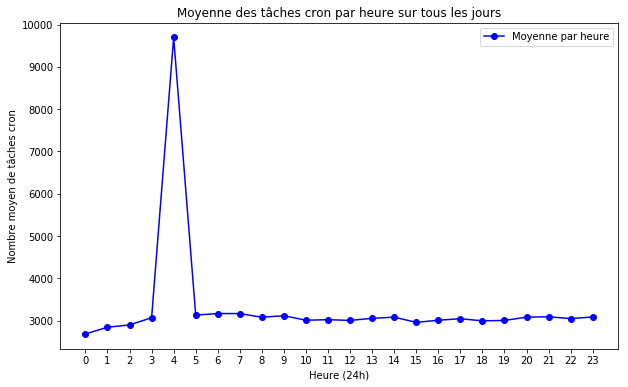

In [41]:
# Calcul du nombre moyen de tâches cron par heure
# Chemin du répertoire contenant tous les fichiers Parquet
parquet_path = "gs://bucket_test_spark/notebooks/jupyter/Thunderbird_parsed/"  

# Lire tous les fichiers Parquet dans le répertoire
df = spark.read.parquet(parquet_path)

# Filtrer les tâches cron (basé sur le champ Component ou Content)
cron_df = df.filter((col("Component").like("%cron%")) | (col("Content").like("%cron%")))

# Extraire l'heure à partir du champ Time et la convertir en entier pour un tri correct
cron_df = cron_df.withColumn("Hour", date_format(col("Time"), "HH").cast("int"))

# Compter les tâches par jour et par heure
cron_count = cron_df.groupBy("Date", "Hour").agg(count("*").alias("Cron_Count"))

# Calculer la moyenne des tâches cron par heure sur tous les jours
average_cron = cron_count.groupBy("Hour").agg(avg("Cron_Count").alias("Avg_Cron_Count"))

# Conversion en Pandas pour Matplotlib et tri des heures
average_pd = average_cron.toPandas().sort_values(by="Hour")

# Tracer et enregistrer le graphique
plt.figure(figsize=(10, 6))
plt.plot(average_pd['Hour'], average_pd['Avg_Cron_Count'], marker='o', color='b', label="Moyenne par heure")
plt.xlabel("Heure (24h)")
plt.ylabel("Nombre moyen de tâches cron")
plt.title("Moyenne des tâches cron par heure sur tous les jours")
plt.xticks(range(24))  
plt.legend()

plt.savefig("cron_average_per_hour.png")
plt.show()
plt.close()



Utilisateur avec le plus de connexions root par heure le 12 janvier:
+-----------+------------+-----+
|hour_of_day|User        |count|
+-----------+------------+-----+
|0          |tbird-admin1|7    |
|1          |eadmin1     |7    |
|1          |tbird-admin1|7    |
|1          |aadmin1     |7    |
|2          |tbird-admin1|7    |
|3          |tbird-admin1|7    |
|4          |cadmin1     |9    |
|4          |aadmin1     |9    |
|4          |eadmin1     |9    |
|4          |badmin1     |9    |
|5          |tbird-admin1|7    |
|6          |dadmin1     |37   |
|7          |dadmin1     |83   |
|8          |dadmin1     |32   |
|9          |dadmin1     |27   |
|10         |dadmin1     |36   |
|11         |dadmin1     |96   |
|12         |dadmin1     |129  |
|13         |aadmin1     |9    |
|13         |eadmin1     |9    |
|13         |badmin1     |9    |
|13         |cadmin1     |9    |
|14         |tbird-admin1|7    |
|14         |eadmin1     |7    |
+-----------+------------+-----+
only sh

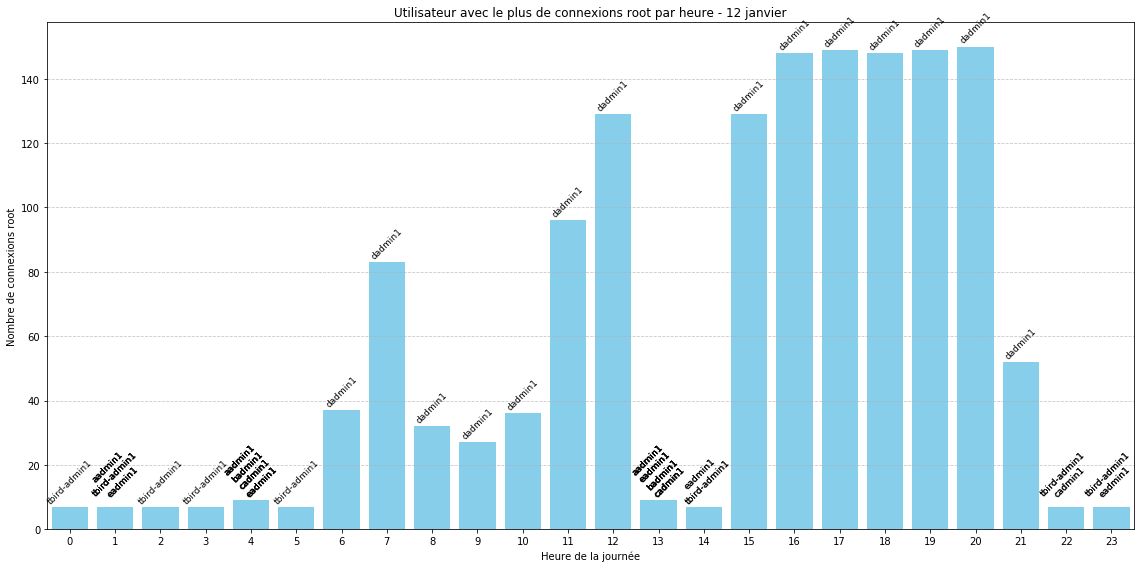

In [42]:
# Utilisateur avec le plus de connexions root

# Chemin vers le fichier parquet
parquet_path = "gs://bucket_test_spark/notebooks/jupyter/Thunderbird_parsed/"  

# Lire les données parquet
df = spark.read.parquet(parquet_path)


# Si on veut afficher que pour le 12 du mois de Janvier
df = df.filter((col("Month") == "Jan") & (col("Day") == "12"))

df = df.withColumn("hour_of_day", hour(col("Time")))


# Filtrer uniquement les sessions ouvertes pour root
df_root_sessions = df.filter(col("Content").like("%session opened for user root%"))

# Compter le nombre de sessions root ouvertes par utilisateur et par jour
user_root_sessions_by_hour = df_root_sessions.groupBy("hour_of_day", "User").count()

# Pour chaque jour, trouver l'utilisateur qui a ouvert le plus de sessions root
window_spec = Window.partitionBy("hour_of_day").orderBy(col("count").desc())
top_users_by_hour = user_root_sessions_by_hour \
    .withColumn("rank", rank().over(window_spec)) \
    .filter(col("rank") == 1) \
    .select("hour_of_day", "User", "count") \
    .orderBy("hour_of_day")


print("Utilisateur avec le plus de connexions root par heure le 12 janvier:")
top_users_by_hour.show(24, False)

# Convertir en pandas DataFrame pour visualisation
pandas_df = top_users_by_hour.toPandas()

# Vérifier si nous avons des données
if len(pandas_df) > 0:
    # Créer un DataFrame avec toutes les heures de la journée (0-23)
    all_hours = pd.DataFrame({'hour_of_day': range(24)})
    pandas_df = pd.merge(all_hours, pandas_df, on='hour_of_day', how='left')
    pandas_df = pandas_df.fillna({'count': 0, 'User': 'Aucun'})
    pandas_df['count'] = pandas_df['count'].astype(int)
    
    # Créer un graphique à barres
    plt.figure(figsize=(16, 8))
    
    # Créer le graphique à barres
    bars = plt.bar(pandas_df['hour_of_day'], pandas_df['count'], color='skyblue')
    
    # Ajouter les noms d'utilisateurs au-dessus des barres qui ont des connexions
    for i, row in pandas_df.iterrows():
        if row['count'] > 0:
            users = pandas_df[pandas_df['hour_of_day'] == row['hour_of_day']]['User'].tolist()
            user_text = "\n".join(users)
            plt.text(row['hour_of_day'], row['count'] + 0.5, user_text, 
                    ha='center', va='bottom', fontsize=9, rotation=45)
    
    # Configurer les axes et le titre
    plt.xlabel('Heure de la journée')
    plt.ylabel('Nombre de connexions root')
    plt.title('Utilisateur avec le plus de connexions root par heure - 12 janvier')
    plt.xticks(range(24))
    plt.xlim(-0.5, 23.5)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Sauvegarder le graphique
    plt.savefig("most_active_root_user_jan12_by_hour.png")
    
    # Afficher le graphique
    plt.show()
    plt.close()
    
else:
    print("Aucune donnée trouvée pour les connexions root le 12 janvier.")


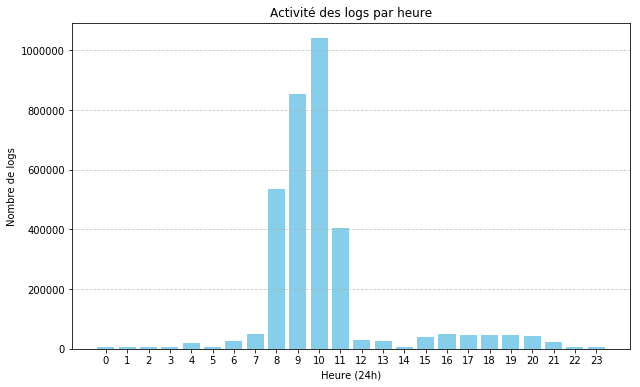

In [22]:
# Extraction de l'heure et calcul du nombre de logs par heure
# Extract hour from the "Time" column
df = df.withColumn("Hour", date_format(col("Time"), "HH").cast("int"))

# Count the number of logs per hour
activity_by_hour = df.groupBy("Hour").agg(count("*").alias("Activity_Count"))

# Convert to Pandas for visualization
activity_pd = activity_by_hour.toPandas().sort_values(by="Hour")

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(activity_pd['Hour'], activity_pd['Activity_Count'], color='skyblue')
plt.xlabel("Heure (24h)")
plt.ylabel("Nombre de logs")
plt.title("Activité des logs par heure")
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("log_activity_per_hour.png")
plt.show()
plt.close()


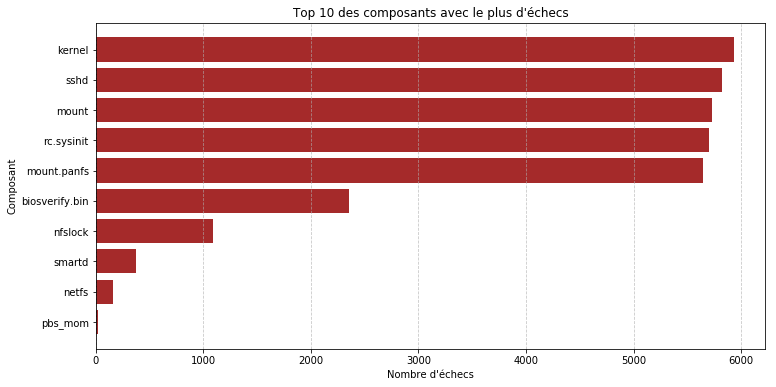

In [23]:
# Echecs en fonction des différents composant.

# Filter logs containing "failed"
failed_processes_df = df.filter(col("Content").like("%failed%"))

# Count failures by component
failed_by_component = failed_processes_df.groupBy("Component").agg(count("*").alias("Failure_Count"))

# Convert to Pandas
failed_by_component_pd = failed_by_component.toPandas().sort_values(by="Failure_Count", ascending=False).head(10)

# Plot failures by component
plt.figure(figsize=(12, 6))
plt.barh(failed_by_component_pd["Component"], failed_by_component_pd["Failure_Count"], color='brown')
plt.xlabel("Nombre d'échecs")
plt.ylabel("Composant")
plt.title("Top 10 des composants avec le plus d'échecs")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.savefig("failed_components.png")
plt.show()
plt.close()


In [40]:
# Identification des nœuds avec une activité excessive de logs.

node_activity = df.groupBy("Location").agg(count("*").alias("Total_Logs"))

# Count errors/warnings per node
error_df = df.filter(col("Content").rlike("(?i)error|failed|warning"))
node_errors = error_df.groupBy("Location").agg(count("*").alias("Error_Count"))

# Count cron job executions per node
cron_df = df.filter(col("Component").like("%cron%"))
cron_jobs = cron_df.groupBy("Location").agg(count("*").alias("Cron_Jobs"))

# Merge stats
node_stats = node_activity.join(node_errors, "Location", "left").join(cron_jobs, "Location", "left").fillna(0)

# Convert to Pandas for visualization
node_pd = node_stats.toPandas()
node_pd.set_index("Location", inplace=True)

node_pd = node_pd[node_pd["Total_Logs"] > 300]


# Identify noisy nodes (excessive logging)
NOISE_THRESHOLD = node_pd["Total_Logs"].quantile(0.95)
noisy_nodes = node_pd[node_pd["Total_Logs"] > NOISE_THRESHOLD]
print("Noisy Nodes:")
print(noisy_nodes[0:10])

Noisy Nodes:
             Total_Logs  Error_Count  Cron_Jobs
Location                                       
dn208/dn208        4114           72         44
dn317/dn317        3201           57         36
dn763/dn763        3201           57         36
dn416/dn416        3893           71         34
dn228/dn228        4104           76         43
dn691/dn691        4150           80         37
src@dadmin2       18598            0         24
dn739/dn739        3194           58         31
dn225/dn225        4097           72         36
dn725/dn725        3195           64         41


In [36]:
# Calcul de la durée des sessions de connexion en root

# Filter only root login and logout events
login_df = df.filter(col("Content").like("%session opened for user root%")) \
    .select(col("User"), col("PID"), col("Time").alias("Login_Time"), col("Location"), col("Date"))

logout_df = df.filter(col("Content").like("%session closed for user root%")) \
    .select(col("User"), col("PID"), col("Time").alias("Logout_Time"), col("Location"), col("Date"))

# Join login and logout logs on User, PID, and Location
session_df = login_df.alias("login").join(
    logout_df.alias("logout"),
    (col("login.User") == col("logout.User")) &
    (col("login.PID") == col("logout.PID")) &
    (col("login.Location") == col("logout.Location")) &
    (col("login.Date") == col("logout.Date")),
    "left"  # Left join to keep unmatched login events
).select(
    col("login.User"), col("login.PID"), col("login.Location"),
    col("login.Login_Time"), col("logout.Logout_Time")
)

# Compute session duration (handle missing logout cases)
session_df = session_df.withColumn(
    "Session_Duration",
    when(col("Logout_Time").isNotNull(), unix_timestamp(col("Logout_Time")) - unix_timestamp(col("Login_Time")))
    .otherwise(None)  # Optionally flag sessions that never closed
)

session_df.show(10)

+------+-----+-------------+----------+-----------+----------------+
|  User|  PID|     Location|Login_Time|Logout_Time|Session_Duration|
+------+-----+-------------+----------+-----------+----------------+
| an100|20086|  an100/an100|  16:01:01|   16:01:01|            null|
|an1023| 8076|an1023/an1023|  11:10:08|       null|            null|
| an119|18047|  an119/an119|  01:01:01|       null|            null|
| an151|20161|  an151/an151|  22:01:01|   22:01:01|            null|
| an152|19441|  an152/an152|  13:02:45|       null|            null|
| an253|18054|  an253/an253|  01:01:01|       null|            null|
| an293| 7836|  an293/an293|  20:01:01|   20:01:01|            null|
| an333| 4742|  an333/an333|  05:01:01|   05:01:01|            null|
| an340| 7242|  an340/an340|  11:09:55|       null|            null|
| an345| 7373|  an345/an345|  06:51:57|       null|            null|
+------+-----+-------------+----------+-----------+----------------+
only showing top 10 rows

